In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

import gseapy as gp
from gseapy.plot import gseaplot
from matplotlib.ticker import MultipleLocator

import pickle
import os 

In [60]:
os.chdir('/Users/soheepark/03-GEO근감소/Data/gse_both/')

In [61]:
osothers = pd.read_csv('./osothers/results_osothers.csv', index_col=0)
with open('./osothers/results_osothers_dds.pkl', 'rb') as f:
    osothers_dds = pickle.load(f)

In [62]:
# 설정
num = 0
res = osothers
dds = osothers_dds

dic = {'Sarcopenia vs Control' : ['Sarcopenia','Control']}
vol = list(dic.keys())[num]
dic[vol]

lfc_cutoff = 1
pval_cutoff = 0.05

In [63]:
# p-value의 -log10 변환
res['-log10(pvalue)'] = -np.log10(res['pvalue'])

In [64]:
# 유의한 유전자 필터링
res_sigs = res[(res.pvalue < pval_cutoff)]
res_nosigs = res[(res.pvalue > pval_cutoff)]

# 유의하게 차이나는 유전자 필터링
res_sigs_diff = res_sigs[abs(res_sigs.log2FoldChange) > lfc_cutoff]
res_sigs_up = res_sigs[res_sigs['log2FoldChange'] > lfc_cutoff].sort_values(by='log2FoldChange', ascending=False)
res_sigs_down = res_sigs[res_sigs['log2FoldChange'] < -lfc_cutoff].sort_values(by='log2FoldChange', ascending=True)
res_sigs_middle = res_sigs[res_sigs['log2FoldChange'].between(-lfc_cutoff, lfc_cutoff)]

# 유의하지는 않지만 차이나는 유전자 필터링
res_nosigs_bottom = res_nosigs[(res_nosigs['log2FoldChange'] > lfc_cutoff) | (res_nosigs['log2FoldChange'] < -lfc_cutoff)]

In [65]:
# 유의한 유전자 개수 추출
print(f"Up-regulated: {len(res_sigs_up)}")
print(f"Down-regulated: {len(res_sigs_down)}")
print(f"Intersected: {len(res_sigs) - len(res_sigs_diff)}")
print(f"Total: {len(res_sigs)}") 

Up-regulated: 29
Down-regulated: 7
Intersected: 2801
Total: 2837


## Heatmap

In [68]:
# 히트맵에 표시할 인덱스 생성
dds.obs['Sample'] = dds.obs.index
dds.obs['Samples'] = dds.obs.index.astype(str) + '_' + dds.obs['Condition_ori']

dds_sigs = dds[:, res_sigs_diff.index]
# dds expression table (counts는 normalized 사용)
dds_expr = pd.DataFrame(np.log1p(dds.layers['normed_counts']).T,
                        index=dds.var_names, 
                        columns=dds.obs.Samples)
dds_sigs_expr = dds_expr.loc[res_sigs_diff.index]

In [76]:
# 그룹별 및 환자별 인덱스 정렬을 위한 리스트 생성
# dds.obs['Temp'] = dds.obs['Sample'].apply(lambda x:x.split(' ')[-1]).astype(int)
my_order = dds.obs.sort_values(by=['Condition_ori', 'GEO', 'Temp'], ascending=[False, True, True])['Samples'].values

In [80]:
dds.obs.sort_values(by=['Condition_ori', 'GEO', 'Temp'], ascending=[False, True, True])['Samples']

,Condition,Sample,Temp,GEO,Temp2,Condition_,Condition_ori,Samples
X_50,Control,X_50,50,GSE167186,X_50,Young Healthy,YH,X_50_YH
X_51,Control,X_51,51,GSE167186,X_51,Young Healthy,YH,X_51_YH
X_52,Control,X_52,52,GSE167186,X_52,Young Healthy,YH,X_52_YH
X_53,Control,X_53,53,GSE167186,X_53,Young Healthy,YH,X_53_YH
X_54,Control,X_54,54,GSE167186,X_54,Young Healthy,YH,X_54_YH
...,...,...,...,...,...,...,...,...
X_74,Control,X_74,74,GSE167186,X_74,Old Healthy,OH,X_74_OH
X_75,Control,X_75,75,GSE167186,X_75,Old Healthy,OH,X_75_OH
X_76,Control,X_76,76,GSE167186,X_76,Old Healthy,OH,X_76_OH
X_78,Control,X_78,78,GSE167186,X_78,Old Healthy,OH,X_78_OH


In [70]:
# dds_sigs_expr 행렬 정렬
dds_sigs_expr = dds_sigs_expr.T
dds_sigs_expr = dds_sigs_expr.reindex(my_order).T

In [71]:
dic[vol][0], dic[vol][1]

('Sarcopenia', 'Control')

In [72]:
# 어노테이션 설정
ann_col = dds_sigs.obs['Condition']
ann_col.index = dds_sigs.obs['Samples']

# 애노테이션 색상 설정
ann_colors = {'Group': {dic[vol][0]: '#66CDAA', dic[vol][1]: '#FFA07A'}} # 초록 66CDAA, 분 FFA07A

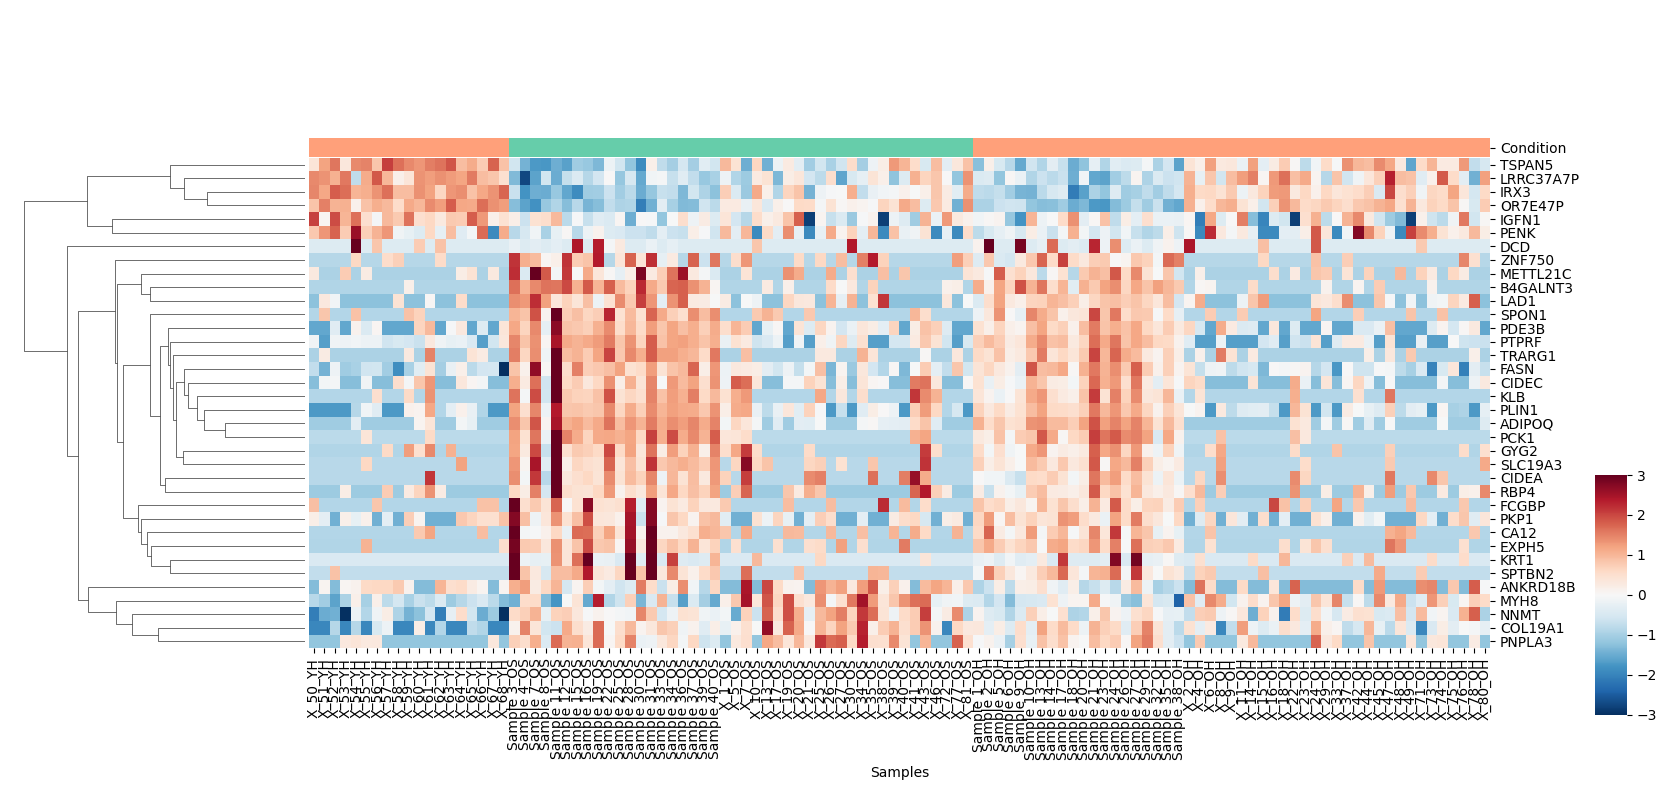

In [74]:
# 히트맵 그리기
sns.clustermap(dds_sigs_expr, 
               z_score=0, # standard_scale=0,
               cmap = 'RdBu_r', 
               center=0,
               xticklabels=True,
               yticklabels=True,
               cbar_pos=(1, 0.1, 0.02, 0.3),
               figsize=(16,8), #(10,16),#(8, 16),
               col_colors=ann_col.map(ann_colors['Group']),
               vmin=-3,
               vmax=3,
               col_cluster=None)
plt.title(f'')
plt.show()

## Volcanoplot

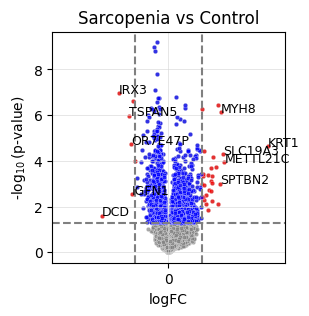

In [58]:
# 볼케이노 플롯 그리기
plt.figure(figsize=(3, 3))

# 기본 플랏
dot_size = 10
alpha_value = 0.7
sns.scatterplot(data=res, x='log2FoldChange', y='-log10(pvalue)',
                color='grey', label='_nolegend_', alpha=alpha_value, s=dot_size)
# 유의한 유전자 (빨강)
sns.scatterplot(data=res_sigs_diff, x='log2FoldChange', y='-log10(pvalue)', 
                color='red', label='_nolegend_', alpha=alpha_value, s=dot_size)
sns.scatterplot(data=res_sigs_middle, x='log2FoldChange', y='-log10(pvalue)',
                color='blue', alpha=alpha_value, s=dot_size)
# 유의하지 않은 유전자 (초록)
sns.scatterplot(data=res_nosigs_bottom, x='log2FoldChange', y='-log10(pvalue)', 
                color='green', alpha=alpha_value, s=dot_size)

# 그래프 라인 설정
plt.axhline(y=-np.log10(pval_cutoff), color='grey', linestyle='--')
plt.axvline(x=-lfc_cutoff, color='grey', linestyle='--')
plt.axvline(x=lfc_cutoff, color='grey', linestyle='--')

# x축 범위 조정
max_fc = max(abs(res['log2FoldChange']))
plt.xlim(-max_fc-0.5, max_fc+0.5)

# 그래프 타이틀 및 레전드
plt.title(vol)
plt.xlabel('logFC')
plt.ylabel(r'-$\log_{10}$(p-value)')

# 격자선 추가 및 간격 설정
plt.grid(True, color='lightgrey', linewidth=0.4)
plt.gca().xaxis.set_major_locator(MultipleLocator(5))
plt.gca().yaxis.set_major_locator(MultipleLocator(2))

# 유의한 유전자 이름 추가
res_sigs_up_genes = res_sigs_up.head()
for i in range(res_sigs_up_genes.shape[0]):
    plt.text(x=res_sigs_up_genes['log2FoldChange'].iloc[i], 
             y=res_sigs_up_genes['-log10(pvalue)'].iloc[i], 
             s=res_sigs_up_genes.index[i],
             fontsize=9)

res_sigs_down_genes = res_sigs_down.head()
for i in range(res_sigs_down_genes.shape[0]):
    plt.text(x=res_sigs_down_genes['log2FoldChange'].iloc[i], 
             y=res_sigs_down_genes['-log10(pvalue)'].iloc[i], 
             s=res_sigs_down_genes.index[i],
             fontsize=9)
plt.show()

## Violineplot

In [ ]:
# up-regulated & down-regulated dds expression matrix 정의
dds_sigs_expr_up = dds_expr.loc[res_sigs_up.index]
dds_sigs_expr_down = dds_expr.loc[res_sigs_down.index]

In [ ]:
# top 5 유전자 정의
dds_sigs_expr_up_top5 = dds_sigs_expr_down.head().T
dds_sigs_expr_down_top5 = dds_sigs_expr_down.head().T

In [ ]:
res.loc[res_sigs_up.index].head()

In [ ]:
res.loc[res_sigs_down.index]

In [ ]:

gene = 'DCD' # 'FLG2'
df = dds_expr.T

# group 설정
df['Group'] = df.index.str.split('_').str[-1]

group1 = dic[vol][0]
group2 = dic[vol][1]

# p-value 계산
up_group = df[df['Group'] == group1][gene]
down_group = df[df['Group'] == group2][gene]
t_stat, p_value = ttest_ind(up_group, down_group, equal_var=False)
print(f'{gene}: {t_stat}, {p_value}')

In [ ]:
plt.figure(figsize=(2.5, 3))

group1 = dic[vol][0]
group2 = dic[vol][1]

print(f'{group1} vs {group2}')

# 바이올린 플랏
sns.violinplot(x='Group', y=gene, data=df.reset_index(), 
           palette={group1: '#66CDAA', group2: '#FFA07A'}, inner='box')
sns.stripplot(x='Group', y=gene, data=df.reset_index(), 
          color='k', size=3, jitter=True, alpha=0.6)
plt.show()